Machine Learning Capstone
=============================

In using the XGBOOST, I used some code from 
 https://www.kaggle.com/tunguz/redefining-treatment-0-57456?scriptVersionId=1349580

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

color = sns.color_palette()

%matplotlib inline



C:\Users\Linggih\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import pandas as pd
import numpy as np

train = pd.read_csv('training_variants')
test = pd.read_csv('test_variants')
trainx = pd.read_csv('training_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
testx = pd.read_csv('test_text', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
'''
train = pd.merge(train, trainx, how='left', on='ID').fillna('')
y = train['Class'].values
train = train.drop(['Class'], axis=1)

test = pd.merge(test, testx, how='left', on='ID').fillna('')
pid = test['ID'].values

'''
# Separate X and Y.
df_all = pd.concat((train, test), axis=0, ignore_index=True)
#df_all['Gene_Share'] = df_all.apply(lambda r: sum([1 for w in r['Gene'].split(' ') if w in r['Text'].split(' ')]), axis=1)
#df_all['Variation_Share'] = df_all.apply(lambda r: sum([1 for w in r['Variation'].split(' ') if w in r['Text'].split(' ')]), axis=1)

print(len(train))
print(len(test))

3321
5668


In [3]:
print("Train Variants and Text shape: ", train.shape, trainx.shape)
print("Test Variants and Text shape: ", test.shape, testx.shape)

Train Variants and Text shape:  (3321, 4) (3321, 2)
Test Variants and Text shape:  (5668, 3) (5668, 2)


In [4]:
print(train.head())
print(trainx.head())

   ID    Gene             Variation  Class
0   0  FAM58A  Truncating Mutations      1
1   1     CBL                 W802*      2
2   2     CBL                 Q249E      2
3   3     CBL                 N454D      3
4   4     CBL                 L399V      4
   ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


In [5]:
train_text = trainx.Text
test_text = testx.Text

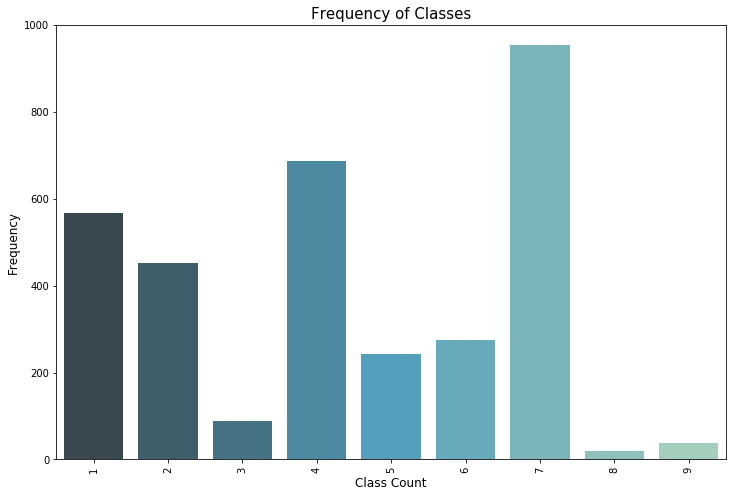

In [6]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=train, palette="GnBu_d")

plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()


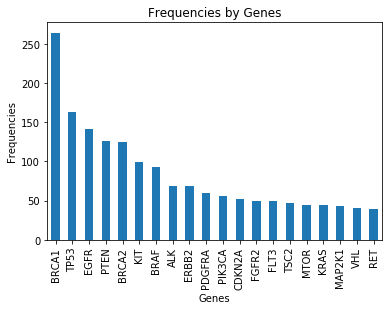

In [7]:
# The most common genes
total_gene = train.Gene.value_counts()
count_gene = total_gene[0:20].plot(kind='bar', title="Frequencies by Genes")
count_gene.set_xlabel('Genes')
count_gene.set_ylabel('Frequencies')
plt.show()

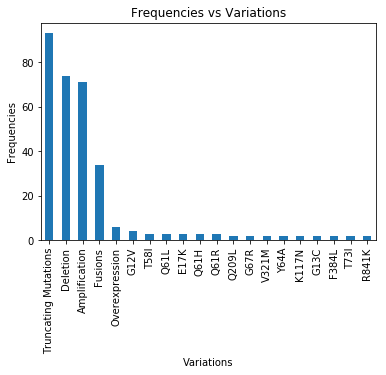

In [8]:
# THe most common variations
common_variations = train.Variation.value_counts()
count_variations = common_variations[0:20].plot(kind='bar', title='Frequencies vs Variations')
count_variations.set_xlabel('Variations')
count_variations.set_ylabel('Frequencies')
plt.show()

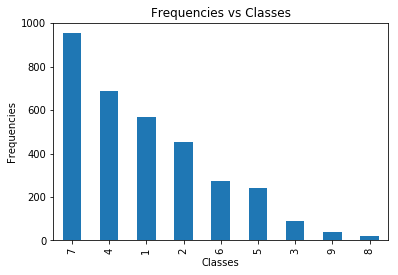

In [9]:
# Count of Classes
most_classes = train.Class.value_counts()
count_classes = most_classes.plot(kind='bar', title='Frequencies vs Classes')
count_classes.set_xlabel('Classes')
count_classes.set_ylabel('Frequencies')
plt.show()

In [10]:
# Cleaning the text in hoping to get better results.
import re

def cleaning(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", str(text))
    text = text.lower().split()
    stops = {'fig.', 'figure', 'cells', 'cell', 'table'
     'so', 'his', 't', 'y', 'ours', 'herself', 
     'your', 'all', 'some', 'they', 'i', 'of', 'didn', 
     'them', 'when', 'will', 'that', 'its', 'because', 
     'while', 'those', 'my', 'don', 'again', 'her', 'if',
     'further', 'now', 'does', 'against', 'won', 'same', 
     'a', 'b', 'c', 'd', 'e','f','g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 
     'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'w', 'y', 'z',
     'during', 'who', 'here', 'have', 'in', 'being', 
     'it', 'other', 'once', 'itself', 'hers', 'after', 're',
     'just', 'their', 'himself', 'theirs', 'whom', 'then', 'd', 
     'out', 'm', 'mustn', 'where', 'below', 'about', 'isn',
     'shouldn', 'wouldn', 'these', 'me', 'to', 'doesn', 'into',
     'the', 'until', 'she', 'am', 'under', 'how', 'yourself',
     'couldn', 'ma', 'up', 'than', 'from', 'themselves', 'yourselves',
     'off', 'above', 'yours', 'having', 'mightn', 'needn', 'on', 
     'too', 'there', 'an', 'and', 'down', 'ourselves', 'each',
     'hadn', 'ain', 'such', 've', 'did', 'be', 'or', 'aren', 'he', 
     'should', 'for', 'both', 'doing', 'this', 'through', 'do', 'had',
     'own', 'but', 'were', 'over', 'not', 'are', 'few', 'by', 
     'been', 'most', 'no', 'as', 'was', 'what', 's', 'is', 'you', 
     'shan', 'between', 'wasn', 'has', 'more', 'him', 'nor',
     'can', 'why', 'any', 'at', 'myself', 'very', 'with', 'we', 
     'which', 'hasn', 'weren', 'haven', 'our', 'll', 'only', 'before'}
    

    text = [word for word in text if not word in stops]
    text = " ".join(text)
    text = text.replace("."," ").replace(","," ")
    return(text)


In [11]:
train_text_clean = []
for i in train_text:
    meta = cleaning(i)
    train_text_clean.append(meta)

In [12]:
test_text_clean = []
for i in test_text:
    meta = cleaning(i)
    test_text_clean.append(meta)

In [13]:
train_text_clean[0][:100]

'cyclin-dependent kinases cdks regulate variety fundamental cellular processes  cdk10 stands one last'

In [14]:
# Checking the most common words.
from collections import Counter
for i in range(10):
    print('\n Doc ', str(i))
    check = Counter(train_text_clean[i].split())
    print(check.most_common()[:10])


 Doc  0
[('cyclin', 90), ('cdk10', 81), ('ets2', 54), ('expression', 43), ('1', 42), ('protein', 38), ('levels', 35), ('fam58a', 33), ('star', 33), ('2', 32)]

 Doc  1
[('c-cbl', 153), ('mutations', 66), ('lung', 56), ('mutation', 43), ('egfr', 43), ('1', 41), ('samples', 33), ('met', 33), ('cancer', 32), ('0', 29)]

 Doc  2
[('c-cbl', 153), ('mutations', 66), ('lung', 56), ('mutation', 43), ('egfr', 43), ('1', 41), ('samples', 33), ('met', 33), ('cancer', 32), ('0', 29)]

 Doc  3
[('cbl', 104), ('mutations', 69), ('cases', 50), ('aupd', 42), ('upn', 38), ('mutation', 37), ('2', 34), ('3', 29), ('analysis', 29), ('case', 26)]

 Doc  4
[('mutations', 150), ('cbl', 121), ('binding', 64), ('cancer', 62), ('stability', 40), ('effects', 33), ('1', 32), ('activity', 30), ('cbl-e2', 30), ('protein', 30)]

 Doc  5
[('mutations', 150), ('cbl', 121), ('binding', 64), ('cancer', 62), ('stability', 40), ('effects', 33), ('1', 32), ('activity', 30), ('cbl-e2', 30), ('protein', 30)]

 Doc  6
[('mut

In [15]:
# Limit the features to get into the vectorizer.
max_features = 500


In [16]:

tfidf = TfidfVectorizer(min_df=5, max_features=max_features, ngram_range=(1,3),
                        strip_accents='unicode',
                        lowercase =True, analyzer='word', token_pattern=r'\w+',
                        use_idf=True, smooth_idf=True, sublinear_tf=True, 
                        stop_words = 'english')
tfidf.fit(train_text_clean)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=500, min_df=5,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w+', tokenizer=None, use_idf=True,
        vocabulary=None)

In [17]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=200)
tsvdfit = tsvd.fit(tfidf.transform(train_text_clean))

In [18]:
def featuresEngineering(texts_part, variations_parts):
    temp = variations_parts.copy()
    print("Factorize...")
    temp.Gene = pd.factorize(variations_parts.Gene)[0]
    temp.Variation = pd.factorize(variations_parts.Variation)[0]
    temp.Gene_variation_ratio = temp.Gene/temp.Variation
    
    print("tfidf...")
    temp_tfidf = tfidf.transform(texts_part)
    temp.tfidf_sum = temp_tfidf.sum(axis=1)
    temp.tfidf_mean = temp_tfidf.mean(axis=1)
    temp.tfidf_len = (temp_tfidf!=0).sum(axis=1)
    
    print("lsa")
    temp_col = list(temp.columns)
    temp_lsa = tsvd.transform(temp_tfidf)
    
    for i in range(np.shape(temp_lsa)[1]):
        temp_col.append('lsa'+str(i+1))
    temp = pd.concat([temp, pd.DataFrame(temp_lsa, index=temp.index)], axis=1)
    
    return temp, temp_col

In [19]:
train_df, train_columns = featuresEngineering(train_text_clean, train)

Factorize...
tfidf...
lsa


In [20]:
test_df, test_columns = featuresEngineering(test_text_clean, test)

Factorize...
tfidf...
lsa


In [21]:
classes = train.Class - 1
print('Original', Counter(train.Class), '\n Rehashed: ', Counter(classes))

Original Counter({7: 953, 4: 686, 1: 568, 2: 452, 6: 275, 5: 242, 3: 89, 9: 37, 8: 19}) 
 Rehashed:  Counter({6: 953, 3: 686, 0: 568, 1: 452, 5: 275, 4: 242, 2: 89, 8: 37, 7: 19})


In [22]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(['ID', 'Class'], axis=1), classes, test_size = 0.33, random_state = 0)

# Show the results of the split
print(format(X_train.shape))
print(format(X_test.shape))

(2225, 202)
(1096, 202)


In [23]:
print(train_df)

        ID  Gene  Variation  Class         0         1         2         3  \
0        0     0          0      1  0.752828 -0.019792 -0.118816 -0.104973   
1        1     1          1      2  0.763223 -0.138636  0.059093 -0.105341   
2        2     1          2      2  0.763223 -0.138636  0.059093 -0.105341   
3        3     1          3      3  0.736831 -0.030943  0.129126 -0.099866   
4        4     1          4      4  0.770890  0.016294 -0.074732  0.088066   
5        5     1          5      4  0.770890  0.016294 -0.074732  0.088066   
6        6     1          6      5  0.770890  0.016294 -0.074732  0.088066   
7        7     1          7      1  0.832240 -0.133820  0.090564 -0.033577   
8        8     1          8      4  0.821791 -0.153531 -0.071258  0.126092   
9        9     1          9      4  0.674953 -0.258520 -0.094937  0.121560   
10      10     1         10      4  0.770890  0.016294 -0.074732  0.088066   
11      11     1         11      4  0.832313 -0.060180 -0.109799

In [24]:
# Import XGB here
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV

print('Format a Train and Validation Set for XGB')
#xgb_train = xgb(data = X_train, label= y_train)
print(X_train.head())

Format a Train and Validation Set for XGB
      Gene  Variation         0         1         2         3         4  \
2584   213       2344  0.792837  0.464723 -0.019916  0.176561 -0.011646   
41       4          0  0.857841  0.106734  0.078842 -0.242670  0.035995   
3158   241       2875  0.768989 -0.121276 -0.140588  0.010308  0.128111   
3043   229       2789  0.872104 -0.227419  0.162298  0.016134 -0.083465   
1423   114       1288  0.860835 -0.166277 -0.059200 -0.061887 -0.072811   

             5         6         7    ...          190       191       192  \
2584 -0.135318 -0.045641 -0.100110    ...     0.004557 -0.008744 -0.003142   
41   -0.064959 -0.061499 -0.002669    ...    -0.003688  0.001870 -0.009329   
3158 -0.032617  0.294138 -0.069502    ...    -0.003998  0.009877 -0.012359   
3043  0.039937  0.006146 -0.008942    ...     0.000352 -0.001732  0.007349   
1423 -0.029517  0.003831  0.167234    ...    -0.008529  0.017030  0.001721   

           193       194       195    

C:\Users\Linggih\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [25]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
params = {
        'eta': 0.03,
        'max_depth':4,
        
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 9,
        'gamma': 0,
        'seed': 0,
        'silent': True}
watchlist = [(xgb.DMatrix(X_train, y_train), 'train'), (xgb.DMatrix(X_test, y_test), 'valid')]
model = xgb.train(params, xgb.DMatrix(X_train, y_train), 1000,  watchlist, verbose_eval=50, early_stopping_rounds=100)

score1 = metrics.log_loss(y_test, model.predict(xgb.DMatrix(X_test), ntree_limit=model.best_ntree_limit), labels = list(range(9)))
print(score1)


[0]	train-mlogloss:2.14442	valid-mlogloss:2.15303
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[50]	train-mlogloss:1.11098	valid-mlogloss:1.33835
[100]	train-mlogloss:0.79162	valid-mlogloss:1.13208
[150]	train-mlogloss:0.622115	valid-mlogloss:1.04967
[200]	train-mlogloss:0.504315	valid-mlogloss:1.00937
[250]	train-mlogloss:0.42525	valid-mlogloss:0.993614
[300]	train-mlogloss:0.367531	valid-mlogloss:0.989033
[350]	train-mlogloss:0.325649	valid-mlogloss:0.991018
[400]	train-mlogloss:0.291598	valid-mlogloss:0.996307
Stopping. Best iteration:
[304]	train-mlogloss:0.363479	valid-mlogloss:0.988564

0.988564026638


In [26]:
pred = model.predict(xgb.DMatrix(test_df.drop(['ID'], axis=1)), ntree_limit=model.best_ntree_limit+80)


In [27]:
submission = pd.DataFrame(pred, columns=['class'+str(c+1) for c in range(9)])
submission['ID'] = test_df.index

In [28]:
submission.head(20)

,class1,class2,class3,class4,class5,class6,class7,class8,class9,ID
0,0.156054,0.523648,0.007488,0.018490,0.080548,0.074140,0.137482,0.001172,0.000978,0
1,0.834022,0.049171,0.001842,0.080161,0.006944,0.008206,0.016528,0.000330,0.002797,1
2,0.289553,0.388575,0.006498,0.015875,0.057809,0.028878,0.209614,0.002102,0.001096,2
3,0.485948,0.254935,0.002662,0.030820,0.035607,0.009661,0.177609,0.001508,0.001249,3
4,0.837213,0.038452,0.000323,0.095592,0.002643,0.006223,0.018634,0.000422,0.000499,4
5,0.717828,0.014277,0.000600,0.254202,0.003213,0.007151,0.001209,0.001013,0.000508,5
6,0.654675,0.143194,0.000913,0.104182,0.014202,0.036573,0.044114,0.001649,0.000500,6
7,0.760595,0.015051,0.000626,0.149830,0.020652,0.009597,0.042656,0.000397,0.000595,7
8,0.158534,0.382434,0.004339,0.121122,0.038922,0.112775,0.173405,0.005308,0.003160,8
9,0.018200,0.665920,0.007159,0.061838,0.028311,0.058204,0.157470,0.001388,0.001510,9


### Benchmark Model

To make it fair, this project will use decision tree to compare it with xgboost.

In [29]:
# importing necessary libraries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# training a DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

dtree_model = DecisionTreeClassifier(max_depth = 9).fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)

# creating a confusion matrix

print(len(dtree_predictions))
print(print(dtree_predictions))

1096
[6 5 0 ..., 3 0 6]
None


In [30]:
onehot_dtree = pd.get_dummies(dtree_predictions)
print(onehot_dtree.head())

   0  1  2  3  4  5  6  8
0  0  0  0  0  0  0  1  0
1  0  0  0  0  0  1  0  0
2  1  0  0  0  0  0  0  0
3  0  0  0  1  0  0  0  0
4  0  0  0  1  0  0  0  0


In [31]:
import lightgbm as lgb



In [32]:
train_data = lgb.Dataset(X_train, label=y_train)
param_lgb = {'num_leaves':150, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param_lgb['metric'] = ['auc', 'binary_logloss']

In [33]:
# Training our model using lightgbm
num_round = 50
lgbm = lgb.train(param_lgb, train_data, num_round)

y_pred_lgb = lgbm.predict(X_test)
y_pred_lgb[0:5]

array([ 0.95843249,  0.94711773,  0.66896926,  0.89815873,  0.93504069])

In [34]:
import datetime
now = datetime.datetime.now()
submission.to_csv('xgb_'+str(now.strftime("%Y-%m-%d-%H-%M"))+'.csv', index=False)

In [35]:
test_var_stage2 = pd.read_csv('stage2_test_variants')
test_x_stage2 = pd.read_csv('stage2_test_text.csv', sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])


In [36]:
trial2 = test_x_stage2
numbers = []

for i in range(0, len(test_x_stage2)):
    try:
        if int(test_x_stage2.ID[i]):
            continue
    except:
        numbers.append(i)
        

In [37]:
whole_text = []
for i in numbers:
    i = int(i)
    step = test_x_stage2.Text[i-1] + test_x_stage2.ID[i]
    trial2.set_value(i-1, 'Text', step)

trial2_dropped = trial2.drop([16, 208, 791])

print(len(trial2_dropped))
print(test_x_stage2.Text[15] == trial2.Text[15])

print(len(trial2))


986
True
989


In [38]:
test_text_stage2 = trial2_dropped.Text


In [39]:
test_text_stage2_clean = []


for i in test_text_stage2:
    meta = cleaning(i)
    test_text_stage2_clean.append(meta)
    
    
test_tex_stage2_clean = tfidf.fit(test_text_stage2_clean)


test_stage2_df, test_stage2_columns = featuresEngineering(test_text_stage2_clean, test_var_stage2)


Factorize...
tfidf...
lsa


In [40]:
print(len(test_text_stage2_clean))
print(len(test_var_stage2))


986
986


In [41]:
pred_stage2 = model.predict(xgb.DMatrix(test_stage2_df.drop(['ID'], axis=1)), ntree_limit=model.best_ntree_limit)

In [42]:
def generateSubmission(file):
    submission_stage2 = pd.DataFrame(file, columns=['class'+str(c+1) for c in range(9)])
    #submission_stage2 = pd.DataFrame(pred_stage2, columns=['class'+str(c+1) for c in range(9)])
    #test_stage2_df.index +=1
    stage2_id = test_stage2_df.index
    submission_stage2.insert(loc=0, column='ID', value=stage2_id)
    
    import datetime
    now = datetime.datetime.now()
    
    submission_stage2.to_csv('xgb_stage2_'+str(now.strftime("%Y-%m-%d-%H-%M"))+'.csv', index=False)
    print(test_stage2_df.index)
    
print(generateSubmission(pred_stage2))

RangeIndex(start=0, stop=986, step=1)
None
